## Packages

In [1]:
from random import randint
from copy import copy

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

#import folium
#import geopandas as gpd

#from prettytable import PrettyTable

## Load Data

individual data from input.csv.  Workforce proprotions from demographics.csv

In [2]:
expected_input_dtypes = {'patient_id': "uint64",
                         'age': "uint32",
                         'sex': 'category',
                         'care_home_type': 'category',
                         'ethnicity': 'category',
                         'stp': 'category',
                         'msoa': 'category',
                         'imd': 'category',
                         'rural_urban': 'category',
                         'bmi': 'float64',
}

df = pd.read_csv("../output/input.csv", dtype = expected_input_dtypes)
df['covid_vaccine_tpp_table'] = pd.to_datetime(df['covid_vaccine_tpp_table']
).fillna(value=pd.to_datetime('1/1/1915')) 

KeyError: 'covid2_vaccine_tpp_table'

In [34]:
expected_workforce_dtypes = {'workforce': 'category',
                             'metric': 'category',
                             'format': 'category',
                             'value': 'float64'
}

df_workforce = pd.read_csv("./data/demographics.csv", dtype = expected_workforce_dtypes)
df_workforce.dtypes

workforce    category
metric       category
format       category
value         float64
dtype: object

## Replace NaNs with '0'

In [35]:
# order matches codelist.py
condition_cols = [
    'solid_organ_transplantation',
    'chemo_or_radio',
    'lung_cancer',
    'cancer_excl_lung_and_haem',
    'haematological_cancer',
    'bone_marrow_transplant',
    'cystic_fibrosis',
    'severe_asthma',
    'current_copd',
    'sickle_cell_disease',
    'permanant_immunosuppression',
    'temporary_immunosuppression',
    'dmards',
    'chronic_cardiac_disease',
    'intel_dis_incl_downs_syndrome',
    'dialysis',
    'non_severe_asthma',
    'other_respiratory_conditions',
    'heart_failure',
    'other_heart_disease',
    'diabetes',
    'chronic_kidney_disease',
    'chronic_liver_disease',
    'other_neuro',
    'recent_salbutamol_count',
    'psychosis_schiz_bipolar',
    'asplenia'
]

# Clean - replace NaNs
df.loc[:, condition_cols] = (
    df.loc[:, condition_cols]
 #   .where(df.loc[:, condition_cols].isnull(), 1)
    .fillna(value=0)
    .astype(int)
)

## Replace NaNs with '-99'

In [36]:
senti_val = -99

df['sex'] = df.sex.cat.add_categories([senti_val])
df['rural_urban'] = df.rural_urban.cat.add_categories([senti_val])
df['stp'] = df.stp.cat.add_categories([senti_val])
df['msoa'] = df.msoa.cat.add_categories([senti_val])
df['imd'] = df.imd.cat.add_categories([senti_val])
df['ethnicity'] = df.ethnicity.cat.add_categories([senti_val])
df['care_home_type'] = df.care_home_type.cat.add_categories([senti_val])

df.loc[:, "sex"].fillna(value=senti_val, inplace=True)
df.loc[:, "rural_urban"].fillna(value=senti_val, inplace=True)
df.loc[:, "stp"].fillna(value=senti_val, inplace=True)
df.loc[:, "msoa"].fillna(value=senti_val, inplace=True)
df.loc[:, "imd"].fillna(value=senti_val, inplace=True)
df.loc[:, "ethnicity"].fillna(value=senti_val, inplace=True)
df.loc[:, "bmi"].fillna(value=senti_val, inplace=True)
df.loc[:, "care_home_type"].fillna(value="U", inplace=True)

## Adding features

In [37]:
# Create new features for "with definitions"
df["cancer_excl_lung_and_haem_with_chemo_or_radio"] = (
    df["cancer_excl_lung_and_haem"] * df["chemo_or_radio"]
)
df["lung_cancer_with_chemo_or_radio"] = (
    df["lung_cancer"] * df["chemo_or_radio"]
)
df["non_severe_asthma_with_recent_salbutamol_count"] = (
    df["non_severe_asthma"] * df["recent_salbutamol_count"]
)

df.describe(include = 'all')

,covid_vaccine_tpp_table,age,sex,care_home_type,ethnicity,stp,msoa,imd,rural_urban,solid_organ_transplantation,...,chronic_liver_disease,other_neuro,bmi,recent_salbutamol_count,psychosis_schiz_bipolar,asplenia,patient_id,cancer_excl_lung_and_haem_with_chemo_or_radio,lung_cancer_with_chemo_or_radio,non_severe_asthma_with_recent_salbutamol_count
count,10000,10000.000000,10000,10000,10000.0,10000,10000,10000,10000,10000.000000,...,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.0,10000.0
unique,3,NaN,2,4,6.0,2,2,3,2,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,1915-01-01 00:00:00,NaN,F,U,-99.0,STP2,MSOA1,300,urban,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,9900,NaN,5199,8481,2500.0,5008,5024,7025,9024,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
first,1915-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,2020-12-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,40.511400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.010000,...,0.010000,0.010000,15.302018,0.010000,0.010000,0.010000,50070.388000,0.000300,0.0,0.0
std,NaN,23.935416,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.099504,...,0.099504,0.099504,39.225862,0.099504,0.099504,0.099504,28898.714615,0.017319,0.0,0.0
min,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,...,0.000000,0.000000,-99.000000,0.000000,0.000000,0.000000,36.000000,0.000000,0.0,0.0
25%,NaN,21.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,...,0.000000,0.000000,18.326160,0.000000,0.000000,0.000000,24856.250000,0.000000,0.0,0.0


## Define Risk

In [38]:
clinExtrVuln_condition_cols = [
    "solid_organ_transplantation",
    "cancer_excl_lung_and_haem_with_chemo_or_radio",
    "lung_cancer_with_chemo_or_radio",
    "haematological_cancer",
    "bone_marrow_transplant",
    "cystic_fibrosis",
    # "severe_asthma", (awaiting definition)
    "current_copd",
    "sickle_cell_disease",
    "permanant_immunosuppression",
    "temporary_immunosuppression",
    "dmards",
    "chronic_cardiac_disease",
    "intel_dis_incl_downs_syndrome",
    "dialysis",
]

atRisk_condition_cols = [
    "non_severe_asthma_with_recent_salbutamol_count",
    "other_respiratory_conditions",
    "heart_failure",
    "other_heart_disease",
    "diabetes",
    "chronic_kidney_disease",
    "chronic_liver_disease",
    "other_neuro",
    "psychosis_schiz_bipolar",
    "asplenia",
]

In [39]:
df["num_clinExtrVuln_conditions"] = df.loc[:, clinExtrVuln_condition_cols].sum(
    axis=1
)
df["num_atRisk_conditions"] = df.loc[:, atRisk_condition_cols].sum(axis=1)
df["risk"] = 0

risk_conditionals = [
    (df["num_clinExtrVuln_conditions"] > 0),
    (df["num_atRisk_conditions"] > 0) | (df["bmi"] >= 40),
    (df["num_atRisk_conditions"] == 0)
    & (df["num_clinExtrVuln_conditions"] == 0)
    & (df["bmi"] < 40)
]
risk_values = ["high", "medium", "low"]

df["risk"] = np.select(risk_conditionals, risk_values)

## Define Prioirty (exluding workforce considerations)
based on November Green Book 

In [40]:
priority_labels = [
    "Older Residents & care workers in Care Homes",
    "80+ & Health and care Workers",
    "75+",
    "70+ & Clinically Extremely Vulnerable Adults",
    "65+",
    "Adults who are at Risk",
    "60+",
    "55+",
    "50+",
    "Rest",
]

In [41]:
df["priority"] = 0

priority_conditionals = [
    (df["age"] >= 65) & (df["care_home_type"] != "U"),
    (df["age"] >= 80) & (df["care_home_type"] == "U"),
    (df["age"] >= 75) & (df["care_home_type"] == "U"),
    ((df["age"] >= 70) & (df["care_home_type"] == "U"))
    | ((df["risk"] == "high") & (df["age"] >= 18)),
    (df["age"] >= 65) & (df["care_home_type"] == "U"),
    ((df["age"] < 65) & (df["risk"] == "medium") & (df["age"] >= 18))
    | ((df["age"] < 65) & (df["care_home_type"] != "U")),
    (df["age"] >= 60) & (df["risk"] == "low"),
    (df["age"] >= 55) & (df["risk"] == "low"),
    (df["age"] >= 50) & (df["risk"] == "low"),
    (df["age"] < 50)
]
priority_values = list(range(1, len(priority_labels) + 1))

df["priority"] = np.select(priority_conditionals, priority_values)

In [42]:
freq = df["priority"].value_counts().sort_index()
# Ensure all ten priorities have a value or zero
freq = freq.reindex([1,2,3,4,5,6,7,8,9,10], fill_value=0) 

freq_output = freq.copy(deep=True)

freq_output = freq_output.reset_index().rename({"index": "order"}, axis=1)
freq_output.index = priority_labels

freq_output.to_csv("../output/PriorityCounts_NoWorkforce.csv")
print(freq)

1      296
2      436
3      327
4     1148
5      406
6     1907
7      330
8      415
9      456
10    4279
Name: priority, dtype: int64


Output disease propensities for clinical extremely vulnerable and at risk as a sense check. Ensure these outputs will never give less than 7 for any combination.  

In [43]:
clinExtrVuln_propensity = (
    df[(df["risk"] == "high")]
    .groupby(clinExtrVuln_condition_cols)
    .size()
    .reset_index(name="Count")
    .sort_values(by="Count", ascending=False)
)
clinExtrVuln_propensity.loc[
    (clinExtrVuln_propensity["Count"] < 7), "Count"
] = 7
clinExtrVuln_propensity.to_csv(
    "../output/clinExtrVuln_propensity.csv", index=False
)

atRisk_propensity = (
    df[(df["risk"] == "high")]
    .groupby(atRisk_condition_cols)
    .size()
    .reset_index(name="Count")
    .sort_values(by="Count", ascending=False)
)
atRisk_propensity.loc[(atRisk_propensity["Count"] < 7), "Count"] = 7
atRisk_propensity.to_csv("../output/atRisk_propensity.csv", index=False)

Mapping to be added for Priority counts per STP or MSOA.

In [44]:
#dfmap = gpd.read_file("./data/STP.geojson")
#rand = [randint(0, 9) for p in range(0, len(dfmap.index))]
#dfmap["Value"] = rand

In [45]:
#min_lat, max_lat = 48.77, 60
#min_lon, max_lon = -9.05, 5

#kanton_map = folium.Map(
#    location=[54.6, -3.4],
#    tiles="Mapbox Bright",
#    zoom_start=7,
#    min_lat=min_lat,
#    max_lat=max_lat,
#    min_lon=min_lon,
#    max_lon=max_lon,
#    max_zoom=18,
#    min_zoom=5,
#)

#kanton_map.choropleth(
#    geo_data="./data/STP.geojson",
#    data=dfmap,
#    columns=["stp20cd", "Value"],
#    key_on="feature.properties.stp20cd",
#    # threshold_scale=[0,1,3,5,9],
#    fill_color="BuPu",
#)

#kanton_map

## Workforce calculations for age bands (including risk exclusions)

In [46]:
# As we need to adapt profiles, we need to first have a factor to use for the dummy data
factor = len(df.index) / int(
    df_workforce.loc[
        (df_workforce["workforce"] == "England")
        & (df_workforce["metric"] == "all")
    ].value
)

# From the calculation above, we also need a factor for the number of higher risk people
high_risk_prop = len(df[(df["risk"] == "high") & (df["age"] >= 18)]) / len(
    df.index
)
medium_risk_prop = len(df[(df["risk"] == "medium") & (df["age"] >= 18)]) / len(
    df.index
)
risk_prop = high_risk_prop + medium_risk_prop

In [47]:
# Calculate total for each group
df_wf_tot = (
    df_workforce.loc[df_workforce["metric"] == "all", ["workforce", "value"]]
    .copy(deep=True)
    .reset_index(drop=True)
)

df_wf_tot["factor_total"] = df_wf_tot["value"].astype(int) * factor

df_wf_tot = df_wf_tot.set_index("workforce")
df_wf_tot = df_wf_tot.drop("value", axis=1)
df_wf_tot = df_wf_tot.drop("England", axis=0)

wf_tot = df_wf_tot["factor_total"]

In [48]:
# 5-year age-bands for workforce (assume no workforce above 70)
sc_list = ["SocialCare_Residential", "SocialCare_NonResidential"]

lower_ab_sc = 32 / 37
lower_ab_not_sc = 32 / 36

age_bands = ["under_55", "55_59", "60_64", "65+"]

df_wf_ab = (
    df_workforce.loc[
        df_workforce["metric"].isin(age_bands),
        ["workforce", "metric", "value"],
    ]
    .copy(deep=True)
    .reset_index(drop=True)
)
df_wf_ab["metric"] = df_wf_ab.metric.cat.add_categories(["65_70"])
df_wf_ab.loc[df_wf_ab["metric"] == "65+", "metric"] = "65_70"

for wfg in df_wf_ab["workforce"].unique():
    wfg_lower = df_wf_ab[
        (df_wf_ab["workforce"] == wfg) & (df_wf_ab["metric"] == "under_55")
    ]["value"].values[0]

    multiplier = lower_ab_sc if wfg in (sc_list) else lower_ab_not_sc

    new_ab_series = [
        pd.Series(
            [wfg, "18_49", wfg_lower * multiplier], index=df_wf_ab.columns
        ),
        pd.Series(
            [wfg, "50_54", wfg_lower * (1 - multiplier)],
            index=df_wf_ab.columns,
        ),
    ]

    df_wf_ab = df_wf_ab.append(new_ab_series, ignore_index=True)

age_bands_updated = ["18_49", "50_54", "55_59", "60_64", "65_70"]

df_wf_ab = df_wf_ab[df_wf_ab["metric"] != "under_55"]
df_wf_ab = df_wf_ab[df_wf_ab["workforce"] != "England"]
df_wf_ab = df_wf_ab.sort_values(["workforce", "metric"]).reset_index(drop=True)

In [49]:
wf_not_65_70 = (
    df_wf_ab[~(df_wf_ab["metric"] == "65_70")]
    .groupby("workforce")
    .sum()["value"]
)

wf_ab = dict()

for ab in age_bands_updated:
    _wf = df_wf_ab[df_wf_ab["metric"] == ab].set_index("workforce")["value"]

    wf_ab.update({ab: _wf})

In [50]:
freq_wf = copy(freq)
freq_wf = freq_wf.astype("float")

freq_wf[1] = freq[1] + wf_tot["SocialCare_Residential"]
freq_wf[2] = freq[2] + (wf_tot.sum() - wf_tot["SocialCare_Residential"])
freq_wf[3] = freq[3]
freq_wf[4] = freq[4] - high_risk_prop * wf_tot.sum()
freq_wf[5] = freq[5] - (1 - risk_prop) * (wf_ab["65_70"] @ wf_tot)
freq_wf[6] = freq[6] - medium_risk_prop * wf_tot.sum()
freq_wf[7] = freq[7] - (1 - risk_prop) * (wf_ab["60_64"] @ wf_tot)
freq_wf[8] = freq[8] - (1 - risk_prop) * (wf_ab["55_59"] @ wf_tot)
freq_wf[9] = freq[9] - (1 - risk_prop) * (wf_ab["50_54"] @ wf_tot)
freq_wf[10] = freq[10] - (1 - risk_prop) * (wf_ab["18_49"] @ wf_tot)

In [51]:
freq_wf_output = freq_wf.copy(deep=True)

freq_wf_output = freq_wf_output.reset_index().rename(
    {"index": "order"}, axis=1
)
freq_wf_output.index = priority_labels

freq_wf_output.to_csv("../output/PriorityCounts_WithWorkforce.csv")

In [52]:
#wf_table = PrettyTable()
#column_names = [
#    "C-19 Vaccine Priority Categories",
#    "Count with no workforce considered",
#    "Count with workforce considered",
#    "Difference",
#]

#wf_table.add_column(column_names[0], priority_labels)
#wf_table.add_column(column_names[1], freq.values)
#wf_table.add_column(column_names[2], freq_wf.values.round(2))
#wf_table.add_column(column_names[3], (freq.values - freq_wf.values).round(2))
#wf_table.add_row(["", "", "", ""])
#wf_table.add_row(
#    [
#        "Total",
#        freq.values.sum(),
#        freq_wf.values.sum(),
#        (freq.values - freq_wf.values).sum().round(2),
#    ]
#)

#print(wf_table)

## Vaccinated 
group by priority and month.  Set any group less than 7 to 7.

In [72]:
vacc_num = df[['priority','covid_vaccine_tpp_table']].where(df['covid_vaccine_tpp_table']>'2020-01-01').groupby(['priority','covid_vaccine_tpp_table']).size().reset_index(name='counts')
vacc_num.loc[(vacc_num["counts"] < 7), "counts"] = 7
vacc_num.to_csv("../output/VaccinatedByPriorityByMonth.csv")

## Waterfall chart

In [53]:
csum_wf = freq_wf.cumsum().shift(1).fillna(value=0)
csum = freq.cumsum().shift(1).fillna(value=0)

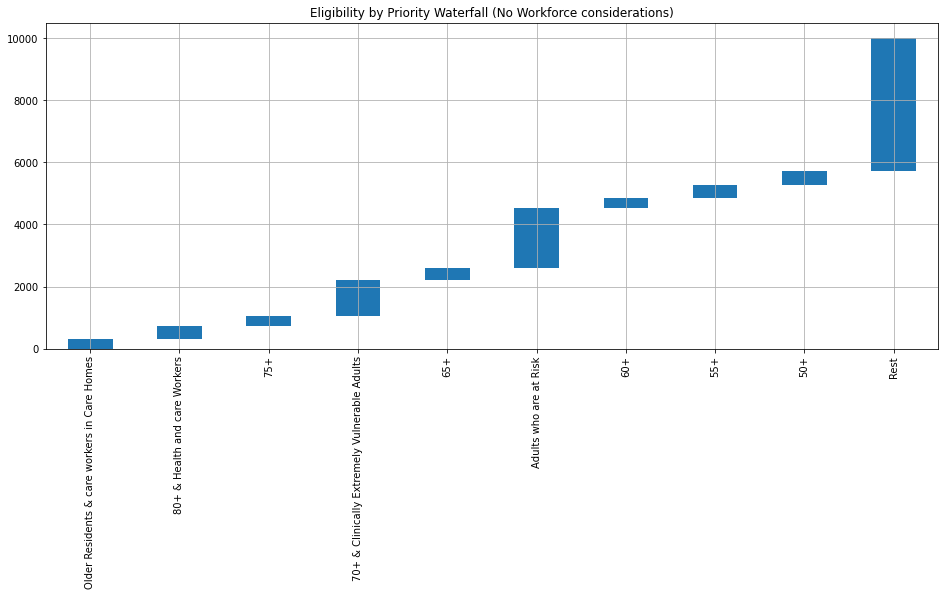

In [54]:
age_plot = freq.plot(
    kind="bar",
    stacked=True,
    bottom=csum,
    legend=None,
    title="Eligibility by Priority Waterfall (No Workforce considerations)",
    figsize=(16, 6),
)

age_plot.set_xticklabels(priority_labels)
age_plot.grid()

plt.savefig("../output/waterfall_age.png")
plt.show()

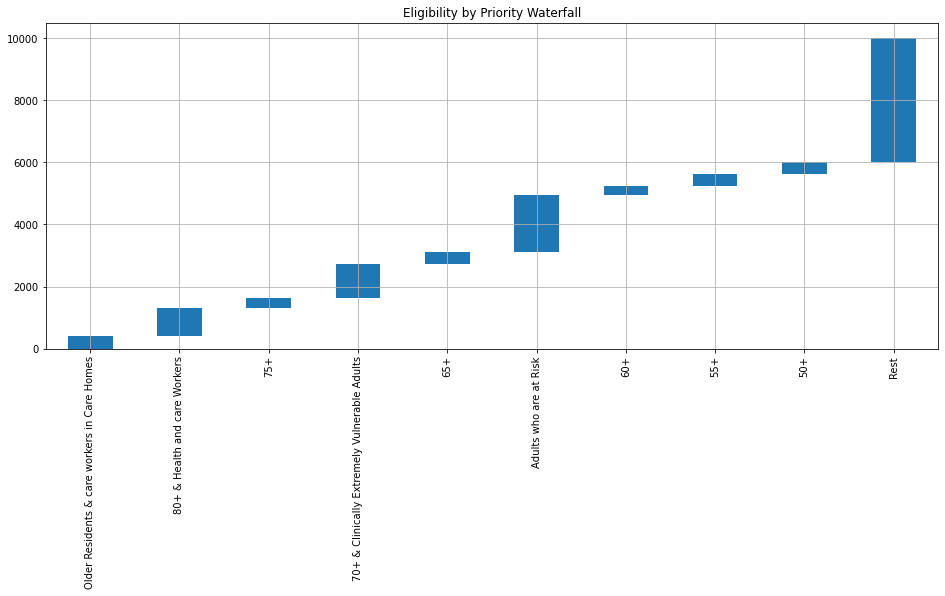

In [55]:
wf_plot = freq_wf.plot(
    kind="bar",
    stacked=True,
    bottom=csum_wf,
    legend=None,
    title="Eligibility by Priority Waterfall",
    figsize=(16, 6),
)

wf_plot.set_xticklabels(priority_labels)
wf_plot.grid()

plt.savefig("../output/waterfall_wf.png")
plt.show()